# HWRS640 - Assignment 1: Computer architecture and parallel computing

## Hossein Yousefi Sohi - Feb 05, 2026








## Problem 1: Supercomputer architecture
### 1.	 Name + location

Frontier was ranked #1 on the TOP500 November 2022 list. It is installed at Oak Ridge National Laboratory in Oak Ridge, Tennessee, United States.

### 2.	 Architecture (CPU, cores, memory, interconnect)

Frontier is an HPE Cray EX235a system built by Hewlett Packard Enterprise and designed as a hybrid CPU–GPU machine. On the TOP500 entry, its compute nodes are based on AMD “Optimized 3rd Gen EPYC” 64-core 2.0 GHz CPUs paired with AMD Instinct MI250X accelerators, and the system uses the HPE Slingshot-11 interconnect. In the November 2022 configuration, TOP500 reports 8,730,112 total cores (TOP500’s accounting of “cores” reflects the benchmark reporting model for the full system).
At the node level, Frontier’s user documentation describes a clear, repeatable building block: 1× 64-core EPYC CPU with 512 GB DDR4, plus 4× MI250X GPUs. Each MI250X contains two GPU dies; the documentation notes you can think of these as 8 GPU devices per node, each with 64 GB of high-bandwidth memory (HBM2E)—i.e., 512 GB HBM2E per node alongside the 512 GB CPU memory.

### 3.	Peak performance (FLOPS)

TOP500 reports two performance numbers for Frontier in November 2022:
- Theoretical peak (Rpeak): 1,685.65 PFLOP/s = 1.68565 × 10¹⁸ FLOP/s (≈ 1.69 EFLOP/s)
- LINPACK achieved (Rmax): 1,102.00 PFLOP/s = 1.10200 × 10¹⁸ FLOP/s (≈ 1.10 EFLOP/s)

### 4.	Capability

Frontier’s impact goes beyond raw FLOPS. By combining CPU–GPU parallelism with very high memory bandwidth and a fast interconnect, it enables either larger simulations or faster time-to-solution. This is especially valuable for kilometer-scale climate/Earth-system ensembles, multi-physics energy and nuclear modeling with uncertainty quantification, and data-intensive workflows where in-situ analysis and scientific machine learning are tightly coupled to simulation output.

## Problem 2: Moore's Law and Linear Regression


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 1. Load the data
file_path = '../data/moores.csv'
df = pd.read_csv(file_path, skiprows=1)

In [4]:
# 2. Clean the data

df['Transistor Count'] = df['Transistor Count'].astype(str)
df['Transistor Count'] = df['Transistor Count'].str.replace(r'\[.*\]', '', regex=True)
df['Transistor Count'] = df['Transistor Count'].str.replace(',', '')
df['Transistor Count'] = pd.to_numeric(df['Transistor Count'], errors='coerce')

df = df.dropna(subset=['Transistor Count', 'Year'])

# Remove any zero or negative counts
df = df[df['Transistor Count'] > 0]


In [5]:
# 3. Perform Linear Regression
# Moore's law: count = a * 2^(year/T)
# log(count) = log(a) + (log(2)/T) * year
X = df[['Year']].values
y = np.log(df['Transistor Count'].values) # Natural log

model = LinearRegression()
model.fit(X, y)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


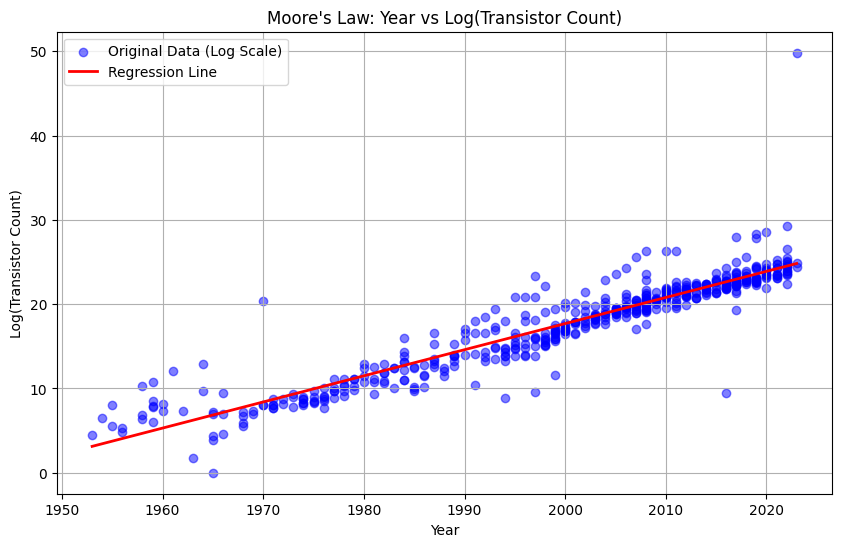

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', alpha=0.5, label='Original Data (Log Scale)')
plt.plot(X, model.predict(X), color='red', linewidth=2, label='Regression Line')
plt.title("Moore's Law: Year vs Log(Transistor Count)")
plt.xlabel("Year")
plt.ylabel("Log(Transistor Count)")
plt.legend()
plt.grid(True)
plt.savefig('moores_law_plot.png')
plt.show()

In [7]:
# 5. Compute Doubling Time
# Slope m = log(2) / T_doubling
# So T_doubling = log(2) / m
slope = model.coef_[0]
doubling_time = np.log(2) / slope
print(f"Calculated Doubling Time (All Data): {doubling_time:.2f} years")
print(f"Difference from 2 years: {doubling_time - 2:.2f} years")

Calculated Doubling Time (All Data): 2.24 years
Difference from 2 years: 0.24 years


In [9]:
# First 10 years
min_year = df['Year'].min()
df_start = df[df['Year'] <= (min_year + 10)]

X_start = df_start[['Year']].values
y_start = np.log(df_start['Transistor Count'].values)

model_start = LinearRegression()
model_start.fit(X_start, y_start)
slope_start = model_start.coef_[0]
doubling_start = np.log(2) / slope_start

## Last 10 years
max_year = df['Year'].max()
df_end = df[df['Year'] >= (max_year - 10)]

X_end = df_end[['Year']].values
y_end = np.log(df_end['Transistor Count'].values)

model_end = LinearRegression()
model_end.fit(X_end, y_end)
slope_end = model_end.coef_[0]
doubling_end = np.log(2) / slope_end

print(f"Doubling Time (First 10 Years): {doubling_start:.2f} years")
print(f"Doubling Time (Last 10 Years): {doubling_end:.2f} years")

Doubling Time (First 10 Years): 4.00 years
Doubling Time (Last 10 Years): 1.44 years


## Problem 3: Row vs column order data access

In [1]:
import numpy as np
import time

# 1. Create a large 2D NumPy array
N = 20000 
data = np.random.rand(N, N)
np.shape(data)

(20000, 20000)

In [2]:
# 2. Function for Row-Major Sum
def sum_row_major(arr):
    rows, cols = arr.shape
    total = 0.0
    for r in range(rows):
        for c in range(cols):
            total += arr[r, c]
    return total

# 3. Function for Column-Major Sum
def sum_col_major(arr):
    rows, cols = arr.shape
    total = 0.0
    for c in range(cols):
        for r in range(rows):
            total += arr[r, c]
    return total

In [4]:
# 4. Measure execution time
repeats = 30
print(f"Starting measurements (repeating {repeats} times)...")

# -- Measure Row Major --
row_times = []
for i in range(repeats):
    start = time.time()
    _ = sum_row_major(data)
    end = time.time()
    duration = end - start
    row_times.append(duration)
    print(f"Row-major run {i+1}/{repeats}: {duration:.4f} sec")

avg_row_time = sum(row_times) / repeats
print(f"Average Row-Major Time: {avg_row_time:.4f} sec\n")

# -- Measure Column Major --
col_times = []
for i in range(repeats):
    start = time.time()
    _ = sum_col_major(data)
    end = time.time()
    duration = end - start
    col_times.append(duration)
    print(f"Col-major run {i+1}/{repeats}: {duration:.4f} sec")

avg_col_time = sum(col_times) / repeats
print(f"Average Column-Major Time: {avg_col_time:.4f} sec\n")

Starting measurements (repeating 30 times)...


KeyboardInterrupt: 

In [ ]:
# 5. Compare with NumPy built-in sum
print("Measuring NumPy built-in sum...")
start = time.time()
for i in range(repeats):
    np_total = np.sum(data)
end = time.time()
avg_numpy_time = (end - start) / repeats
print(f"Average NumPy Sum Time: {avg_numpy_time:.6f} sec\n")

# Comparisons
print(f"Row-Major (Python Loop): {avg_row_time:.4f} s")
print(f"Col-Major (Python Loop): {avg_col_time:.4f} s")
print(f"NumPy Built-in:          {avg_numpy_time:.6f} s")

diff = avg_col_time - avg_row_time
percent = (diff / avg_row_time) * 100
print(f"\nDifference: Column-major was {diff:.4f}s slower ({percent:.2f}%)")
print(f"NumPy was {avg_row_time / avg_numpy_time:.1f}x faster than Python loops.")

## Problem 4: Scaling and parallel computing (25 points)


In [ ]:
import dask.array as da
import dask
import time
import matplotlib.pyplot as plt
import numpy as np

def run_dask_experiment():

    def compute_z_score(shape):
        x = da.random.random(shape, chunks=(1000, 1000))
        mu = x.mean()
        sigma = x.std()
        
        # Compute Z-score
        z = (x - mu) / sigma
        z.sum().compute()

    
    core_counts = [1, 2, 3, 4]
    
    print("--- Starting Strong Scaling Experiment ---")
    fixed_shape = (20000, 20000)
    
    strong_times = []
    
    for n in core_counts:
        print(f"Running with {n} worker(s)...")

        with dask.config.set(scheduler='threads', num_workers=n):
            start_time = time.time()
            compute_z_score(fixed_shape)
            end_time = time.time()
            
        elapsed = end_time - start_time
        strong_times.append(elapsed)
        print(f"  Time: {elapsed:.4f} seconds")

    t1 = strong_times[0]
    speedup = [t1 / t for t in strong_times]
    efficiency = [s / p for s, p in zip(speedup, core_counts)]


    print("\n--- Starting Weak Scaling Experiment ---")
    base_size = 10000 
    
    weak_times = []
    
    for n in core_counts:
        current_shape = (base_size * n, base_size)
        print(f"Running with {n} worker(s) on size {current_shape}...")
        
        with dask.config.set(scheduler='threads', num_workers=n):
            start_time = time.time()
            compute_z_score(current_shape)
            end_time = time.time()
            
        elapsed = end_time - start_time
        weak_times.append(elapsed)
        print(f"  Time: {elapsed:.4f} seconds")

    plt.figure(figsize=(12, 10))

    # Plot 1: Strong Scaling Time
    plt.subplot(2, 2, 1)
    plt.plot(core_counts, strong_times, marker='o')
    plt.title("Strong Scaling: Execution Time")
    plt.xlabel("Number of Cores")
    plt.ylabel("Time (s)")
    plt.grid(True)

    # Plot 2: Speedup
    plt.subplot(2, 2, 2)
    plt.plot(core_counts, speedup, marker='o', color='green', label='Actual')
    plt.plot(core_counts, core_counts, '--', color='gray', label='Ideal')
    plt.title("Strong Scaling: Speedup")
    plt.xlabel("Number of Cores")
    plt.ylabel("Speedup factor")
    plt.legend()
    plt.grid(True)

    # Plot 3: Efficiency
    plt.subplot(2, 2, 3)
    plt.plot(core_counts, efficiency, marker='o', color='orange')
    plt.title("Strong Scaling: Efficiency")
    plt.xlabel("Number of Cores")
    plt.ylabel("Efficiency (Speedup/Cores)")
    plt.ylim(0, 1.1)
    plt.grid(True)

    # Plot 4: Weak Scaling Time
    plt.subplot(2, 2, 4)
    plt.plot(core_counts, weak_times, marker='o', color='purple')
    plt.title("Weak Scaling: Execution Time")
    plt.xlabel("Number of Cores")
    plt.ylabel("Time (s)")
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('dask_scaling_plots.png')
    plt.show()

if __name__ == '__main__':
    run_dask_experiment()